## Desarrollo prueba selección MGM

A continuación se procede a realizar la limpieza y el procesamiento de los datos datos correspondientes a los meses de julio, agosto y septiembre de la planta de generación FV de La Olimpica - Sede montería. Se explicará de manera general qué análisis se va realizó y en los comentarios del código se encuentra al detalle el proceso realizado:

<ul>
    <li/><b>Procesamiento de datos:</b> En esta etapa se procedió a realizar la carga de los datos y observar inicialmente qué tendencia tenían. Al observar que los datos tenían una alta dependencia de la hora del día se procedió a extraer de la columna 'Hora' dos columnas nuevas, que mostrarán de manera independiente la hora y la fecha respectiva a la cual se hizo el registro, además de un plus que es el día de la semana al cual pertenece dicha medición (que en este caso no es tan representativa, pero en otros casos como procesamiento de información de clientes como centros comerciales grandes puede ayudar mucho a la toma de decisiones a nivel de mantenimiento). La finalidad con este procesamiento es realizar un análisis extra que no se pudo evidenciar en los archivos que se recibieron y es: <b>Análisis de información a lo largo del día (registro a registro) de la planta</b> 
</ul>
<ul>
    <li/><b>Limpieza de datos</b>: se pudo evidenciar que existían registros entre las <b>18:30 y las 6:30</b> que no presentaban ningún tipo de aporte a el análisis de la información así que se procedió a eliminar dichos registros y quedar solamente con los registros entre las 6:30 y las 18:30 a lo largo del día.
</ul>
<ul>
    <li/><b>Preparación de datos para análisis:</b> En esta etapa se agruparon los datos en dos categorías: por día de la semana y por hora del día, de esta manera se tiene un registro y un procesamiento de los datos mas detallados y se puede realizar un seguimiento más minucioso al comportamiento de la planta.
</ul>
<ul>
    <li/><b>Graficas:</b> 
    <ul>
        <li/>Se realizaron las gráficas para observar el comportamiento promedio de la demanda de energía y de la generación de la misma a lo largo del día y de esta manera ver si existía algún pico en el consumo  y para evidenciar también algo que a priori es lógico: el pico de generación se encuentra entre las horas del medio día, a su vez se observó una demanda con tendencia constante (lo que da a entender que posiblemente dichos paneles solares sólo estén alimentando sistemas de iluminación y algunos equipos auxiliares).
        <li/> También se realizó la gráfica del comportamiento promedio de la irradiancia a lo largo del día durante los 3 meses de recolección de data.
     </ul>
</ul>
<ul>
    <li/><b>Análisis predictivo:</b> Para este análisis se buscó predecir la potencia generada por la planta dependiendo de la irradiancia incidente en la misma. Para ello se tomaron los registro del documento GerenacionTiempoReal para cada una de las horas entre las 6:30 de la mañana y las 18:30 de la tarde y se procedió a realizar una regresión lineal simple en un inicio(se tomó esta decisión al observar el comportamiento lineal tan marcado de los datos).
</ul>
<ul>
    <li/><b>Modelo de planta FV</b>: Finalmente al realizar la predicción por medio de Scikit-learn se obtuvo el coeficiente y el intercepto de de la ecuación que modela la planta FV y se puede observar al final de este documento.
 </ul>
 

## Importación de librerías

In [3]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from datetime import date
import calendar

## Procesamiento de datos Generación tiempo real

In [6]:
##Carga de archivos
mainpath = r"C:\Users\Usuario\Desktop\pruebaMGM\Datos_Olimpica"
filename = r"GeneraciónTiempoReal.xlsx"
fullpath = os.path.join(mainpath, filename)

##Tratamiento de datos

GTR = pd.read_excel(fullpath, skiprows=2) #Saltamos dos primeras columnas
GTR.columns = ["Hora","PromPoteMonteriaTR[kW]", 'PromdemandaMonteriaTR[kW]','Promedio de irradiancia[W/m2]'] #Nombramos las columnas
GTR[['Día','Hora']] = GTR.Hora.str.split(" ",expand=True,) #Split de horas y días
GTR['Día'] = pd.to_datetime(GTR['Día']) #De string a datetime (cambiamos el formato de la columna a Date time para que Python 
# reconozca dico formato)
GTR['Hora'] = pd.to_datetime(GTR['Hora']).dt.time# De hora a datetime(Se realiza con la msima intención de la linea de arriba)
GTR['Dia Semana'] = GTR['Día'].map(lambda a: calendar.day_name[a.weekday()]) ##Día de la semana para hacer análisis por día
#de la semana en caso de ser necesario


#Convertimos los string de las columnas a números para poder procesarlos.
GTR['PromPoteMonteriaTR[kW]']=GTR['PromPoteMonteriaTR[kW]'].str.replace(',', '.').astype(float)
GTR['PromdemandaMonteriaTR[kW]']=GTR['PromdemandaMonteriaTR[kW]'].str.replace(',', '.').astype(float)
GTR['Promedio de irradiancia[W/m2]']=GTR['Promedio de irradiancia[W/m2]'].str.replace(',', '.').astype(float)



#Sólo dejamos los registros entre las 6:30am y 6:30pm
GTR = GTR.where((GTR['Hora'] <= pd.to_datetime('18:30:00').time())&(GTR['Hora'] >= pd.to_datetime('06:30:00').time()))
GTR.dropna(inplace=True)

#Organizamos las columnas para mejor lectura
GTR = GTR.reindex(columns=['Día','Hora','Dia Semana' ,'PromPoteMonteriaTR[kW]', 'PromdemandaMonteriaTR[kW]',
       'Promedio de irradiancia[W/m2]']) #Reordenamiento de columnas (para mayor comodidad al leer)

#Resultado de primer procesamiento de datos
GTR


,Día,Hora,Dia Semana,PromPoteMonteriaTR[kW],PromdemandaMonteriaTR[kW],Promedio de irradiancia[W/m2]
25,2020-07-01,06:30:00,Wednesday,2.4,304.184,41.18
26,2020-07-01,06:45:00,Wednesday,5.0,328.654,59.80
27,2020-07-01,07:00:00,Wednesday,7.4,328.522,79.51
28,2020-07-01,07:15:00,Wednesday,10.1,330.614,104.69
29,2020-07-01,07:30:00,Wednesday,15.1,331.240,131.03
...,...,...,...,...,...,...
4604,2020-09-30,17:15:00,Wednesday,36.0,332.940,98.00
4605,2020-09-30,17:30:00,Wednesday,21.9,334.856,65.11
4606,2020-09-30,17:45:00,Wednesday,7.7,339.906,27.32
4607,2020-09-30,18:00:00,Wednesday,2.9,343.124,10.88


In [30]:
#Agrupamos por Día y por hora del día los datos 
GTRHour = GTR.groupby('Hora').agg(PromIr = pd.NamedAgg(column='Promedio de irradiancia[W/m2]',aggfunc='mean'),
                                  PromPote = pd.NamedAgg(column='PromPoteMonteriaTR[kW]',aggfunc='mean'),
                                  PromDeman= pd.NamedAgg(column='PromdemandaMonteriaTR[kW]', aggfunc='mean'))

GTRDay = GTR.groupby('Dia Semana').agg(PromIr = pd.NamedAgg(column='Promedio de irradiancia[W/m2]',aggfunc='mean'),
                                  PromPote = pd.NamedAgg(column='PromPoteMonteriaTR[kW]',aggfunc='mean'),
                                  PromDeman= pd.NamedAgg(column='PromdemandaMonteriaTR[kW]', aggfunc='mean'))

## Datos por día de la semana

In [31]:
#Datos por día de la semana para los 3 meses
GTRDay = GTRDay.rename(index={"Friday": "Viernes",
    "Monday": "Lunes",
    "Saturday": "Sabado",
    "Sunday": "Domingo",
    "Thursday":"Jueves",
                    "Tuesday":"Martes",
                    "Wednesday":"Miercoles"})
GTRDay.columns=['Promedio de irradiancia[W/m2]',"PromPoteMonteriaTR[kW]", 'PromdemandaMonteriaTR[kW]']
GTRDay

,Promedio de irradiancia[W/m2],PromPoteMonteriaTR[kW],PromdemandaMonteriaTR[kW]
Dia Semana,,,
Viernes,399.524921,85.838924,307.953777
Lunes,437.785872,95.028325,303.477242
Sabado,416.925546,90.187372,290.928375
Domingo,420.065728,91.939552,288.550800
Jueves,416.539591,89.341102,305.692816
Martes,411.849335,85.975475,314.475429
Miercoles,408.779178,86.283109,316.683456


## Datos por hora del día

In [32]:
#Datos por horas del día para los 3 meses
GTRHour= GTRHour.reset_index()

GTRHour.columns=["Hora",'Promedio de irradiancia[W/m2]',"PromPoteMonteriaTR[kW]", 'PromdemandaMonteriaTR[kW]']
GTRHour

,Hora,Promedio de irradiancia[W/m2],PromPoteMonteriaTR[kW],PromdemandaMonteriaTR[kW]
0,06:30:00,29.392000,2.204706,343.585435
1,06:45:00,54.223636,6.373864,350.773523
2,07:00:00,82.716023,12.615909,355.749955
3,07:15:00,119.608182,20.075000,359.374159
4,07:30:00,157.683409,28.763636,357.305068
5,07:45:00,199.494432,37.406818,350.901977
6,08:00:00,245.876818,46.828409,340.296091
7,08:15:00,293.232955,56.989773,330.701386
8,08:30:00,334.731818,68.078409,329.022545
9,08:45:00,374.136818,73.089773,338.739545


### Función de ayuda para las gráficas (convertir datetime a string)

In [33]:
def insert_dash(hora):
    hora = hora.strftime('%H%M%S')[0:-2]
    return hora[:2] + ':' + hora[2:]
# print(insert_dash(GTRHour['Hora'][0]))

GTRHour['HoraS'] = GTRHour['Hora'].map(lambda a: insert_dash(a))

## Datos por hora del día y Hora en formato string

In [34]:
GTRHour

,Hora,Promedio de irradiancia[W/m2],PromPoteMonteriaTR[kW],PromdemandaMonteriaTR[kW],HoraS
0,06:30:00,29.392000,2.204706,343.585435,06:30
1,06:45:00,54.223636,6.373864,350.773523,06:45
2,07:00:00,82.716023,12.615909,355.749955,07:00
3,07:15:00,119.608182,20.075000,359.374159,07:15
4,07:30:00,157.683409,28.763636,357.305068,07:30
5,07:45:00,199.494432,37.406818,350.901977,07:45
6,08:00:00,245.876818,46.828409,340.296091,08:00
7,08:15:00,293.232955,56.989773,330.701386,08:15
8,08:30:00,334.731818,68.078409,329.022545,08:30
9,08:45:00,374.136818,73.089773,338.739545,08:45


## Consumo y demanda de potencia Olimpica Montería 

<IPython.core.display.Javascript object>


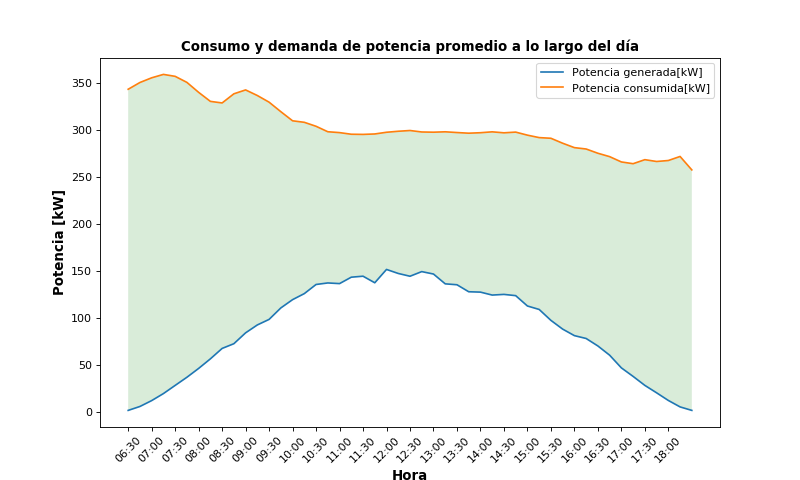

In [25]:
plt.figure(figsize=(10,6))
plt.title('Consumo y demanda de potencia promedio a lo largo del día',fontweight='bold')

plt.plot(GTRHour['HoraS'],GTRHour['PromPote'], label= "Potencia generada[kW]")
plt.plot(GTRHour['HoraS'],GTRHour['PromDeman'], label= "Potencia consumida[kW]")
plt.legend()
plt.xlabel("Hora", fontsize = 12,fontweight='bold')
plt.ylabel("Potencia [kW]", fontsize = 12,fontweight='bold')
plt.xticks(rotation= 45)
plt.xticks(range(0,48,2))
plt.gca().fill_between(range(len(GTRHour['HoraS'])), GTRHour['PromPote'], GTRHour['PromDeman'],facecolor= "green",alpha=0.15)
plt.show()

<IPython.core.display.Javascript object>


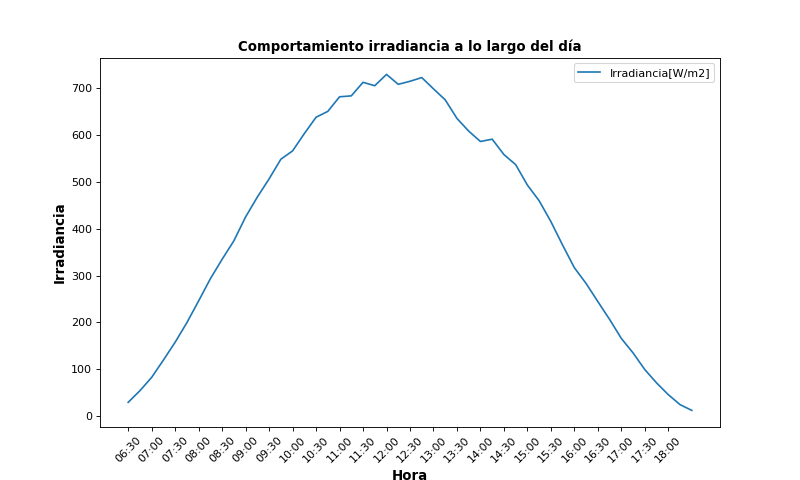

In [26]:
plt.figure(figsize=(10,6))
y = GTRHour['PromIr']
x = GTRHour['HoraS']
plt.plot(x,y,label= "Irradiancia[W/m2]")
plt.xticks(rotation= 45)
plt.xticks(range(0,48,2))
plt.title('Comportamiento irradiancia a lo largo del día',fontweight='bold')
plt.xlabel("Hora", fontsize = 12,fontweight='bold')
plt.ylabel("Irradiancia", fontsize = 12,fontweight='bold')
plt.legend()
plt.show()

## Procesamiento de datos Generación Mensual

In [15]:
filename2 = r"GeneraciónMensual.csv"
fullpath2 = os.path.join(mainpath, filename2)

#Carga de datos
GM = pd.read_csv(fullpath2)


In [16]:
GM['Porcentaje FV'] = GM['Generación Planta FV [kWh]']*100/GM['Consumo Cliente [kWh]']
GM

,Mes,Generación Planta FV [kWh],Consumo Cliente [kWh],Irradiancia Planta FV (W/m²),Porcentaje FV
0,enero,6314.133800,27116.485917,"473,23",23.285221
1,julio,28080.278425,119204.518208,"361,70",23.556388
2,agosto,35674.670725,113677.924167,"412,07",31.382233
3,septiembre,31498.829513,121839.717875,"407,38",25.852678
4,octubre,5697.794417,19921.000500,"388,85",28.601949
5,noviembre,11662.321088,41190.149250,"371,04",28.313374
6,diciembre,21619.963749,88878.983819,"458,92",24.325170


## Predicción de potencia respecto a irradiancia

<IPython.core.display.Javascript object>


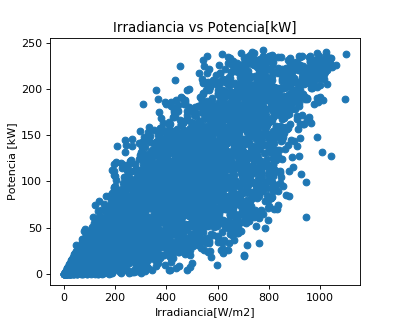

In [27]:
plt.figure(figsize=(5,4))
x = GTR['Promedio de irradiancia[W/m2]']
y = GTR['PromPoteMonteriaTR[kW]']
plt.scatter(x,y)
plt.title('Irradiancia vs Potencia[kW]')
plt.xlabel('Irradiancia[W/m2]')
plt.ylabel('Potencia [kW]')
plt.show()

### Breve descripción de los datos

In [19]:
GTR.describe()

,PromPoteMonteriaTR[kW],PromdemandaMonteriaTR[kW],Promedio de irradiancia[W/m2]
count,4269.000000,4269.000000,4269.000000
mean,89.058913,304.570627,415.487482
std,66.217797,55.788744,265.901834
min,0.000000,165.336000,1.500000
25%,30.900000,266.932000,180.220000
50%,78.600000,303.242000,411.080000
75%,138.400000,340.800000,625.480000
max,243.000000,512.820000,1100.060000


# Análisis predictivo

In [21]:
#Importamos modelo y segmentación de de datos
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

X = GTR['Promedio de irradiancia[W/m2]']
y = GTR['PromPoteMonteriaTR[kW]']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

## Regresión lineal simple

<IPython.core.display.Javascript object>


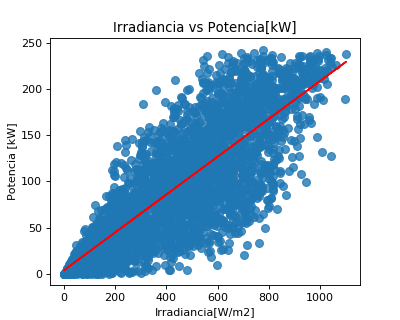

In [22]:
%matplotlib notebook
#Ajustmaos el modelo
linreg = LinearRegression().fit(X_train.values.reshape(-1,1), y_train.values.reshape(-1,1))


plt.figure(figsize=(5,4))
plt.scatter(X_train.values.reshape(-1,1), y_train.values.reshape(-1,1), marker= 'o', s=50, alpha=0.8)
plt.plot(X_train.values.reshape(-1,1), linreg.coef_ * X_train.values.reshape(-1,1) + linreg.intercept_, 'r-')
plt.title('Irradiancia vs Potencia[kW]')
plt.xlabel('Irradiancia[W/m2]')
plt.ylabel('Potencia [kW]')
plt.show()

In [23]:
print('Coeficiente de regresión lineal: ', linreg.coef_[0][0])
print('Intercepción de ecuación: ',linreg.intercept_[0])
print('Score dataset de entrenamiento: ',linreg.score(X_train.values.reshape(-1,1), y_train.values.reshape(-1,1)))
print('Score dataset de prueba: ',linreg.score(X_test.values.reshape(-1,1), y_test.values.reshape(-1,1)))

Coeficiente de regresión lineal:  0.20573060730319695
Intercepción de ecuación:  3.4013430805398315
Score dataset de entrenamiento:  0.6867433944185874
Score dataset de prueba:  0.6860713250896373


## Modelo de planta FV Olimpica - Montería

In [36]:
print('Potencia[kW] = %f * x + %f'%(linreg.coef_[0][0],linreg.intercept_[0]))

Potencia[kW] = 0.205731 * x + 3.401343
